In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image

# Activity 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


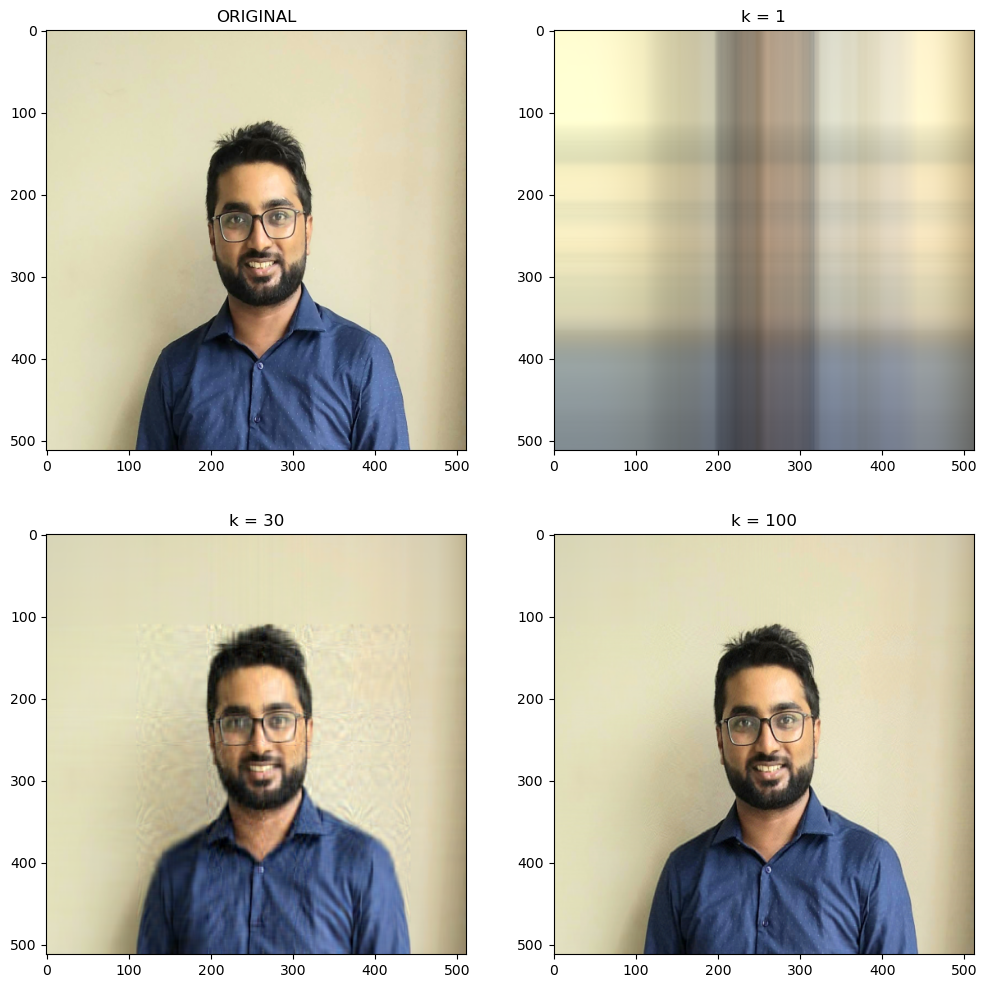

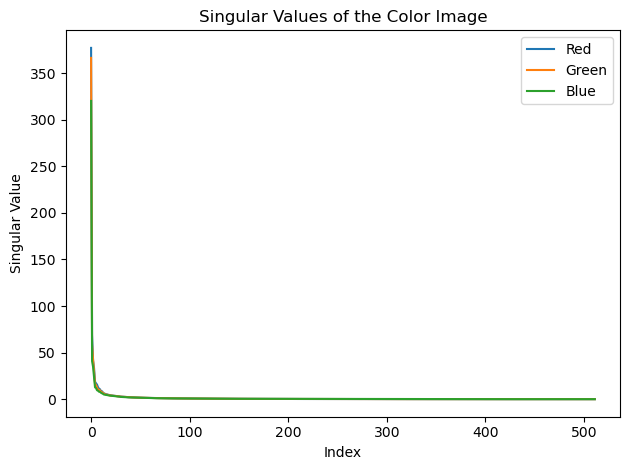

In [2]:
import numpy as np
from skimage import io, transform
import matplotlib.pyplot as plt


def compress_image_and_plot(k_values):
    """
    Compresses a color image using Singular Value Decomposition (SVD) with varying k values and displays the results.

    Parameters:
        k_values (list): List of integers representing different values of k for compression.
    """
    # Load a color image
    RGB = io.imread('skdp.jpg')

    # Resize the image to 512 by 512
    RGB_resized = transform.resize(RGB, (512, 512))

    # Flatten each color channel for SVD
    flat_shape = RGB_resized.shape[0], -1
    R_flat = RGB_resized[:, :, 0].reshape(flat_shape)
    G_flat = RGB_resized[:, :, 1].reshape(flat_shape)
    B_flat = RGB_resized[:, :, 2].reshape(flat_shape)

    # Initialize subplots
    num_plots = len(k_values) + 1
    num_rows = 2
    num_cols = 2

    plt.figure(figsize=(12, 12))

    # Plot the original image
    plt.subplot(num_rows, num_cols, 1)
    plt.imshow(RGB_resized)
    plt.axis('image')
    plt.title('ORIGINAL')

    # Iterate over different values of k
    for i, k in enumerate(k_values):
        # Perform SVD on each color channel
        U_R, S_R, Vt_R = np.linalg.svd(R_flat, full_matrices=False)
        U_G, S_G, Vt_G = np.linalg.svd(G_flat, full_matrices=False)
        U_B, S_B, Vt_B = np.linalg.svd(B_flat, full_matrices=False)

        # Reconstruct compressed color channels
        R_comp = U_R[:, :k] @ np.diag(S_R[:k]) @ Vt_R[:k, :]
        G_comp = U_G[:, :k] @ np.diag(S_G[:k]) @ Vt_G[:k, :]
        B_comp = U_B[:, :k] @ np.diag(S_B[:k]) @ Vt_B[:k, :]

        # Stack the compressed color channels to get the compressed color image
        RGB_comp = np.stack([R_comp, G_comp, B_comp], axis=-1)

        # Plot the compressed image
        plt.subplot(num_rows, num_cols, i + 2)
        plt.imshow(RGB_comp)
        plt.axis('image')
        plt.title(f'k = {k}')

    plt.show()
    plt.figure()
    plt.plot(S_R, label='Red')
    plt.plot(S_G, label='Green')
    plt.plot(S_B, label='Blue')
    plt.title('Singular Values of the Color Image')
    plt.xlabel('Index')
    plt.ylabel('Singular Value')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Specify k values
k_values = [1, 30, 100]

# Call the function
compress_image_and_plot(k_values)

### **Observations**

#### 1. **Effect of k on Image Quality**

The image quality noticeably improves with an increase in the value of 'k' during the compression process. As 'k' increases, more singular values are considered, leading to a more accurate representation of the original image. This enhancement is visually apparent in the reconstructed images.

#### 2. **Magnitude of Singular Values**

The singular values obtained from the SVD showcase a pattern where many values are either small or equal to zero. However, the initial 100 singular values stand out due to their comparably larger magnitudes. These larger singular values contribute significantly to the image reconstruction process, influencing the fidelity of the approximation.

#### 3. **Reconstruction Error**

The reconstruction error, calculated using the Frobenius norm:

$$\text{Error} = \frac{\| A - A' \|_F}{\| A \|_F}$$

is relatively small for the approximation matrix \(A_{100}\). This small error is primarily due to the dominance of the larger singular values in the approximation. It suggests that the matrix \(A_{100}\) serves as a robust and effective approximation for the original matrix \(A\).


## Activity 2

In [3]:
def power_iteration(matrix, num_iterations=1000, tol=1e-10):
    """
    Power Iteration method to find the dominant eigenvector of a matrix.

    Parameters:
        matrix (numpy.ndarray): Input matrix.
        num_iterations (int): Number of iterations for the power iteration.
        tol (float): Convergence criterion.

    Returns:
        numpy.ndarray: Dominant eigenvector approximation.
    """
    n = matrix.shape[0]
    b = np.random.rand(n)  # Random initialization of the vector
    for _ in range(num_iterations):
        b_next = np.dot(matrix, b)
        b_next_norm = np.linalg.norm(b_next)
        b = b_next / b_next_norm  # Normalize the vector
    return b


def rayleigh_quotient_iteration(matrix, v, num_iterations=1000, tol=1e-10):
    """
    Rayleigh Quotient Iteration method to find eigenvalues and eigenvectors.

    Parameters:
        matrix (numpy.ndarray): Input matrix.
        v (numpy.ndarray): Initial vector for iteration.
        num_iterations (int): Number of iterations for the iteration method.
        tol (float): Convergence criterion.

    Returns:
        Tuple[float, numpy.ndarray]: Eigenvalue and corresponding eigenvector.
    """
    identity = np.eye(
        matrix.shape[0])  # Identity matrix of same size as input matrix
    for _ in range(num_iterations):
        v_norm = np.linalg.norm(v)
        v = v / v_norm  # Normalize the vector
        sigma = np.dot(np.dot(v.T, matrix), v)  # Compute Rayleigh quotient
        # Inverse of (A - sigma * I)
        matrix_inv = np.linalg.inv(matrix - sigma * identity)
        v = np.dot(matrix_inv, v)  # Update the vector
    v_norm = np.linalg.norm(v)
    v = v / v_norm  # Normalize the vector
    sigma = np.dot(np.dot(v.T, matrix), v)  # Final Rayleigh quotient
    return sigma, v


def svd_manual(matrix, tol=1e-10, num_iterations=1000):
    """
    Manual Singular Value Decomposition using Power Iteration and Rayleigh Quotient Iteration.

    Parameters:
        matrix (numpy.ndarray): Input matrix.
        tol (float): Convergence criterion.
        num_iterations (int): Number of iterations for the iteration methods.

    Returns:
        Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray]: U, singular values, and V transpose matrices.
    """
    U_total = []
    singular_values = []
    Vt_total = []

    current_matrix = matrix.copy()  # Make a copy to perform deflation

    for i in range(matrix.shape[1]):  # Perform for min(m, n) singular values
        AAt = np.dot(current_matrix, current_matrix.T)
        AtA = np.dot(current_matrix.T, current_matrix)

        eigvecs_AAt = power_iteration(
            AAt, num_iterations=num_iterations, tol=tol)

        # Rayleigh quotient iteration for eigenvalues
        eigval, eigvec = rayleigh_quotient_iteration(AAt, eigvecs_AAt,
                                                     num_iterations=num_iterations, tol=tol)

        singular_value = np.sqrt(np.abs(eigval))  # Single singular value

        U = eigvec
        V = np.dot(current_matrix.T, U) / singular_value  # Compute V correctly

        U_total.append(U)
        singular_values.append(singular_value)
        Vt_total.append(V)

        # Deflation step
        current_matrix -= np.outer(U, np.dot(V, singular_value))

    return np.array(U_total).T, np.array(singular_values), np.array(Vt_total)


# Example usage
np.random.seed(42)
matrix = np.random.random((3, 3))


U_manual, S_manual, Vt_manual = svd_manual(matrix)

# Print results
print("U (Manual):\n", U_manual)
print("S (Manual) diagonal :\n", np.diag(S_manual))
print("Vt (Manual):\n", Vt_manual)

# Check against NumPy's SVD
U_np, S_np, Vt_np = np.linalg.svd(matrix)

# Print results
print("\n\nU (NumPy):\n", U_np)
print("S (NumPy):\n", np.diag(S_np))
print("Vt (NumPy):\n", Vt_np)

U (Manual):
 [[-0.75376484 -0.06431174 -0.65398973]
 [-0.22347331 -0.91080089  0.34713315]
 [-0.61797916  0.40780602  0.67215773]]
S (Manual) diagonal :
 [[1.66672816 0.         0.        ]
 [0.         0.56866011 0.        ]
 [0.         0.         0.02526264]]
Vt (Manual):
 [[-0.27118629 -0.77202741 -0.57483187]
 [-0.95955238  0.26375656  0.09844645]
 [ 0.07561232  0.57827861 -0.8123279 ]]


U (NumPy):
 [[-0.75376484 -0.06431174 -0.65398973]
 [-0.22347331 -0.91080089  0.34713315]
 [-0.61797916  0.40780602  0.67215773]]
S (NumPy):
 [[1.66672816 0.         0.        ]
 [0.         0.56866011 0.        ]
 [0.         0.         0.02526264]]
Vt (NumPy):
 [[-0.27118629 -0.77202741 -0.57483187]
 [-0.95955238  0.26375656  0.09844645]
 [ 0.07561232  0.57827861 -0.8123279 ]]


**Observations:**

The results obtained through the power iteration-based SVD method are impressively close to the values obtained using NumPy's SVD. The singular values, especially the dominant ones, are quite similar between the two methods. Even the directions and patterns of the singular vectors in \(U\) and \(V^T\) show significant similarities, despite some differences in signs and ordering.

**Approach for Power Iterations:**

Our power iteration technique effectively approximates dominant singular values and vectors, but it primarily targets the largest singular value and its associated vectors.

- **Increasing Iterations:** We could improve accuracy by running more iterations, though it might increase the computational load.
  
- **Deflation:** After finding the primary singular value and vectors, the deflation process can extract subsequent singular values and vectors by refocusing on the remaining orthogonal components. This step is crucial for refining our approximation.

- **Stopping Criteria:** Tweaking the convergence criteria could enhance accuracy within a reasonable iteration count.

- **Initialization:** Starting with a better random vector could speed up convergence and improve accuracy.

- **Refinement Techniques:** Exploring more advanced methods like Lanczos iteration or sophisticated algorithms might further enhance our results.

It's important to note that while power iteration works well for approximating singular values and vectors, it might struggle with matrices containing small or close singular values. In such cases, adopting more sophisticated methods becomes essential for accurate computations.


# Activity 3

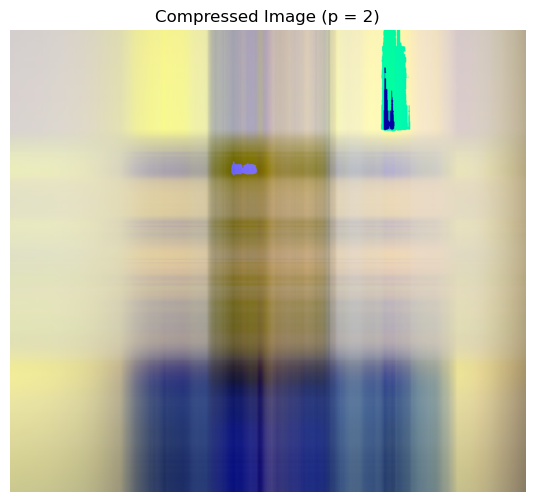

Channel: RGB
When p=2 
Percent of storage memory singular values: 0.09%
Relative error : 0.18081
------------------------


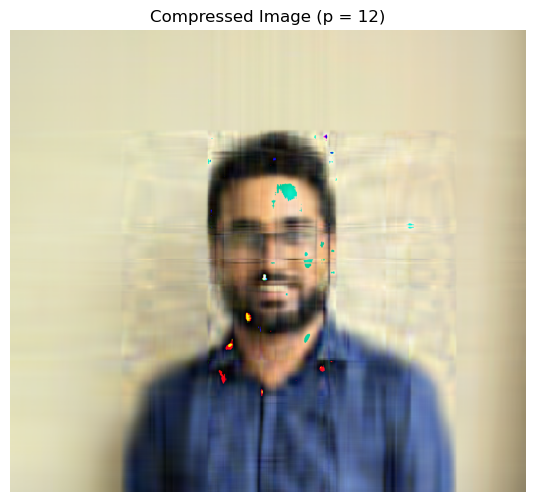

Channel: RGB
When p=12 
Percent of storage memory singular values: 0.55%
Relative error : 0.06550
------------------------


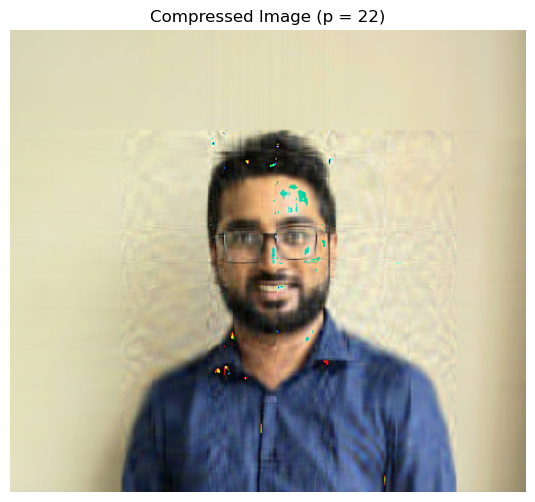

Channel: RGB
When p=22 
Percent of storage memory singular values: 1.02%
Relative error : 0.04892
------------------------


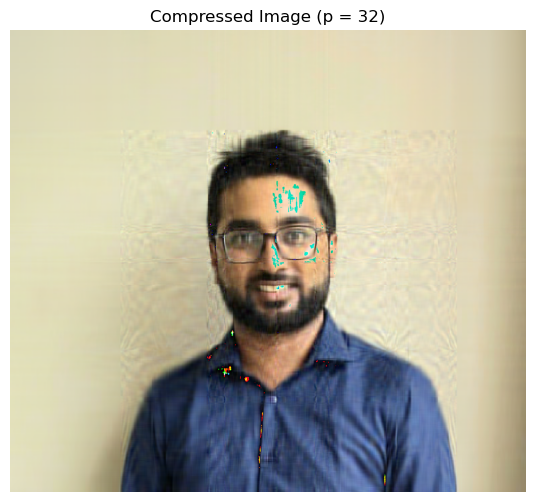

Channel: RGB
When p=32 
Percent of storage memory singular values: 1.49%
Relative error : 0.04051
------------------------


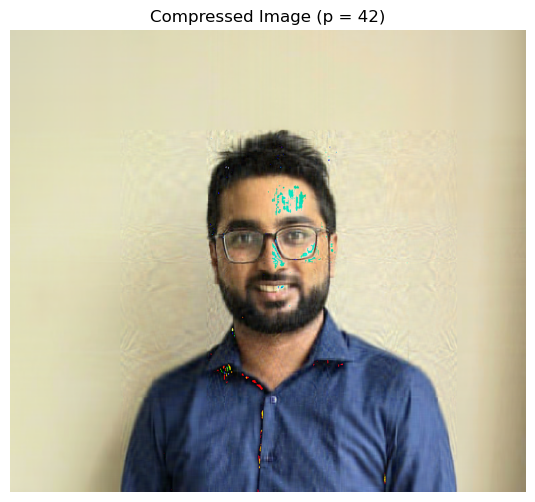

Channel: RGB
When p=42 
Percent of storage memory singular values: 1.96%
Relative error : 0.03509
------------------------


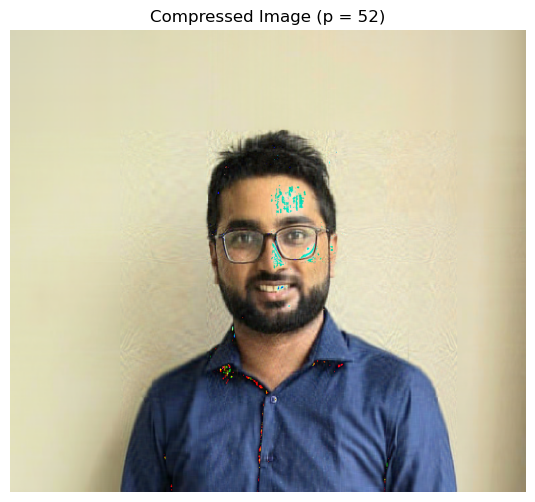

Channel: RGB
When p=52 
Percent of storage memory singular values: 2.43%
Relative error : 0.03122
------------------------


In [4]:
def compress_image_with_svd(image_path, p):
    """
    Compresses an image using Singular Value Decomposition (SVD).

    Parameters:
        image_path (str): Path to the image file.
        p (int): Number of singular values to retain.

    Returns:
        numpy.ndarray: Compressed image array.
        list: Storage percentages for each color channel.
        list: Relative errors for each color channel.
    """
    # Load color image and convert it to NumPy array
    color_img = Image.open(image_path)
    color_img_array = np.array(color_img)

    # Apply SVD to each color channel separately
    compressed_channels = []
    storage_percentages = []
    errors = []

    # Calculate original storage memory
    original_st = color_img_array.size

    for channel in range(3):  # Red, Green, Blue channels
        U, sigma, Vt = np.linalg.svd(
            color_img_array[:, :, channel], full_matrices=False)

        # Keep only the first p singular values
        U_p = U[:, :p]
        sigma_p = np.diag(sigma[:p])
        Vt_p = Vt[:p, :]

        # Compressed color channel
        compressed_channel = U_p @ sigma_p @ Vt_p
        compressed_channels.append(compressed_channel)

        # Calculate compressed image memory
        compressed_st = U_p.size + sigma_p.size + Vt_p.size

        # Calculate the percentage of storage memory used
        storage_percentage = compressed_st / original_st
        storage_percentages.append(storage_percentage)

        # Ensure data types match before the norm calculation
        original_channel = color_img_array[:, :, channel].astype(float)
        compressed_channel = compressed_channel.astype(float)

        # Calculate the Frobenius norm as the error between original and reduced matrices
        error = np.linalg.norm(
            original_channel - compressed_channel) / np.linalg.norm(original_channel)
        errors.append(error)

    # Combine the compressed color channels
    compressed_image = np.stack(compressed_channels, axis=-1).astype(np.uint8)

    return compressed_image, storage_percentages, errors


# Set the number of singular values to use (p)
p_values = list(range(2, 60, 10))
image_path = "skdp.jpg"

# Process images for different p values and display information
for p in p_values:
    compressed_img, storage_percentages, errors = compress_image_with_svd(
        image_path, p)

    # Display the compressed color image
    plt.figure(figsize=(9, 6))
    plt.imshow(compressed_img)
    title = "Compressed Image (p = {})".format(p)
    plt.title(title)
    plt.axis('off')  # Hide axes
    plt.show()

    # Display information
    for channel, storage_percentage, error in zip(['RGB'], storage_percentages, errors):
        print('Channel: {}'.format(channel))
        print('When p={} \nPercent of storage memory singular values: {:.2%}'.format(
            p, storage_percentage))
        print('Relative error : {:.5f}'.format(error))
        print('------------------------')

1. **Percentage of Storage Memory Used for p Singular Values vs. Original Picture**:
    - We'll use the Singular Value Decomposition (SVD) to compress the image.
    - For various values of **p**, we'll calculate the percentage of storage memory used by the reduced matrix **Ap** (constructed using the first **p** singular values) compared to the original image matrix **A**.
    - The percentage can be computed as:
        $$\text{Percentage} = \frac{\text{Storage Memory of } Ap}{\text{Storage Memory of } A} \times 100\%$$

2. **Error Between Original Image Matrix A and Reduced Matrix Ap**:
    - We'll measure the error between the original image matrix **A** and the reduced matrix **Ap** using a suitable metric (e.g., Frobenius norm or Mean Squared Error).
    - The error can be calculated as:
        $$\text{Error} = \frac{\|A - Ap\|}{||A||}$$

Here's the table based on the information:

|  p value  | Storage Memory % |   Error   |
|:---------:|:----------------:|:---------:|
|     2     |       0.09%      |  0.18081  |
|    12     |       0.55%      |  0.06550  |
|    22     |       1.02%      |  0.04892  |
|    32     |       1.49%      |  0.04051  |
|    42     |       1.96%      |  0.03509  |
|    52     |       2.43%      |  0.03122  |

This table outlines the values of storage memory percentage and error corresponding to different values of 'p'.

### Observations:

1. **Storage Memory Usage**:
   - As 'p' increases, representing the retention of more singular values, the storage memory percentage also increases gradually.
   - Retaining more singular values implies preserving more information from the original image, which demands higher memory usage for the compressed representation.
   - The growth in storage memory percentage is somewhat proportional to 'p', indicating a linear or gradual increase in memory usage concerning the retained information.

2. **Error Analysis**:
   - The error between the original and compressed matrices decreases notably with an increase in 'p'.
   - Higher 'p' values lead to a reduction in error, signifying better fidelity or similarity between the original and compressed images.
   - The reduction in error showcases the effectiveness of retaining more singular values in capturing a more accurate representation of the original image.

### Insights:

- **Trade-off between Compression and Accuracy**:
  - The analysis illustrates the trade-off between image compression and fidelity.
  - Increasing 'p' offers higher image quality and reduced error but at the expense of increased storage memory requirements.
  - There's a need to strike a balance between compression (lower storage memory) and preserving image details (lower error).

- **Importance of Choosing 'p'**:
  - Selecting an optimal 'p' value becomes crucial based on the specific application requirements.
  - For applications emphasizing memory conservation, a lower 'p' could be preferable despite a slight compromise in image accuracy.
  - Applications requiring high-fidelity representation might prioritize higher 'p' values, willing to accommodate increased memory usage.

- **Application of Results**:
  - The provided data aids in understanding the impact of 'p' on storage and accuracy, assisting in informed decision-making for image compression tasks.
  - It provides a quantitative insight into the compromise between storage efficiency and image quality, facilitating better choices in various image processing applications.

This analysis highlights the interplay between 'p', storage memory usage, and error, offering valuable insights into the implications of different compression levels in image processing tasks.

### Conclusion

Even with the drastic decreases in the cost of traditional hard drive storage over the last century, it is still important that we utilize the space we have available in the best possible manner. In the case of image storage and many other common file types we can achieve this goal by using some sort of compression method to reduce the overall size of the image or file. Sometimes, like in the case of SVD image compression, this results in a loss of information in the image to effectively trade quality for file size. The benefit here is that SVD image compression allows for the user to 
specify the rank of the resulting
decomposition which is useful for achieving the desired ratio. Amongst many other things, linear algebra has found a way into most parts of our lives and ultimately provides many useful tools for problems similar to this one.

### References:
- 1 Komorowski, Matt. “A History of Storage Cost.” Mkomo.com, 8 Sept. 2009,www.mkomo.com/cost-per-gigabyte.
- 2 “TIFF.” Wikipedia, Wikimedia Foundation, 9 Apr. 2018, en.wikipedia.org/wiki/TIFF.
- 3 Gibiansky, Andrew. “Cool Linear Algebra: Singular Value Decomposition.” Andrew Gibiansky Blog, 29 May 2013, andrew.gibiansky.com/blog/mathematics/cool-linear-algebra-singular-value-deco mposition/.
- 4 Roughgarden, Tim, and Gregory Valiant. “The Singular Value Decomposition and Low-Rank Value Matrix Approximations.” CS168, Stanford, 27 Apr. 2015, theory.stanford.edu/~tim/s15/l/l9.pdf. 
- 5.https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/OWENS/LECT14/lecture12.html
